Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Lastly, hit **Validate**.

If you worked locally, and then uploaded your work to the hub, make sure to follow these steps:
- open your uploaded notebook **on the hub**
- hit the validate button right above this cell, from inside the notebook

These  steps should solve any issue related to submitting the notebook on the hub.

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Zihan Zhou"
COLLABORATORS = ""

---

# Lab 9: Use Bootstrap to Estimate Mean and Variance
** This assignment is due 03/19/2018 at 11:59pm (graded on accuracy) **

## Introduction

In this lab, you will examine the bootstrap in greater detail. The goal is to develop a functional approach to bootstrapping any statistic for any sample.


In [2]:
# Run this cell to set up your notebook

import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

from IPython.display import display, Latex, Markdown


## The Bootstrap Procedure

The bootstrap is a very simple process: 
* Sample with replacement from the original sample (now the **bootstrap population**). These samples are called **bootstrap samples**. We typically take thousands of bootstrap samples (~10,000 is common).
* Calculate the statistic of interest for each bootstrap sample. This statistic is called the **bootstrap statistic**, and the empirical distribution of these bootstrap statistics is an approximation to the **sampling distribution** of the bootstrapped statistic.

Take sample mean estimator as an example. Suppose $\{x_i\}$ are samples coming from an unknown distribution. We can use sample mean $\bar{X} = \frac{1}{n}\sum_{i=1}^n x_i$ to estimate the the mean of the population. However, if we obtain another sample set $\{x_i\}$, we can get very different results. Therefore, computing the sampling distribution (distribution of the sample mean for all possible sample sets) would be very helpful. From such distribution, we can also obtain the bias of this estimator: $E (\bar{X}) - \mu$, and the variance of the estimator: $E[E(\bar{X})-\bar{X}]^2$.

In order to compute the sampling distribution of $\bar{X}$, we could use directly sampling methods. But that require us to obtain several different sets of samples $\{x_i\}$ directly from the population. If we have $m$ sets of **bootstrap samples** and each set contains $n$ subjects (totaling $m*n$ subjects), we can then use $ \hat{X} = \frac{1}{m}\sum_{j=1}^m \bar{X_j}$ to approximate $E(\bar{X})$, and $\frac{1}{m}\sum_{j=1}^m (\hat{X} - \bar{X_j})^2$ to approximate $E[E(\bar{X})-\bar{X}]^2$.

However, in reality, we can only obtain one set of samples (**bootstrap population**). Therefore we can use bootstrap method to resample (sample with replacement) from the **bootstrap population** to obtain $m$ different **bootstrap samples**, each **bootstrap sample** has the same amount of data as in **bootstrap population**.


Your task is to write a generic bootstrap procedure. 

### Question 1
In today's lab, let's try to use bootstrap method to estimate the distribution of sample mean and sample standard deviation  of our midterm grades. You will be given a noisy sample of grades from this midterm, which is the **bootstrap population**. You should use **sampling with replacement** to resample from this dataset again and again to obtain **bootstrap samples** and compute the **bootstrap statistic**.

First, write your own sampling function. The function `simple_resample` samples with replacement from the integers 0 through *n-1* and returns an array of length *n*
with the sampled integers. That is, `simple_resample` produces the indices for
a single bootstrap replicate from the bootstrap population.

Use the `numpy.random.randint` function to do the random sampling. 


In [3]:
def simple_resample(n):
    """
    Args:
        n: an integer
        
    Returns:
        an array of length n of a random sample with replacement of
        the integers 0, 1, ..., n-1
    """
    # YOUR CODE HERE
    return(np.random.randint(low=0, high=n, size=n))  

simple_resample(10)

array([8, 4, 5, 2, 9, 6, 0, 1, 6, 3])

Try your `simple_resample` function on a few cases to see if the sampling looks right.

In [4]:
# chances are less than 5.8 in 10^20 that this test fails when the function is correct
assert (sum((42 in simple_resample(1000)) for _ in range(100000)) in range(63230-1500,63230+1500))
assert (len(simple_resample(1000)) == 1000)

### Question 2

Next let's write the function `bootstrap` which returns an array of length `replicates`, each entry being the `statistic` of interest computed on a bootstrap sample from the `boot_pop` (bootstrap population).

In our case, the `statistic` could be the `np.mean` and `np.std` function. And the `resample` could be `simple_resample`. Here we leave them as parameters so that we could switch to other statistic and resample functions as well.

For each bootstrap sample, you should first use `resample` to obtain samples from the `boot_pop`, then compute the statistic of those samples using the `statistic` method, and put it into your result.

In [5]:
def bootstrap(boot_pop, statistic, resample, replicates = 1000):
    """
    Args:
        boot_pop: an array of shape n x d.
        statistic: a function which takes boot_pop and returns a number.
        resample: a function which takes n and returns a random sample from the integers [0, n)
        replicates: the number of resamples
        
    Returns:
        an array of length replicates, each entry being the statistic computed on a bootstrap sample of the data.
    """
    # YOUR CODE HERE
    result = []
    for j in range(replicates):
        index = resample(len(boot_pop))
        sample = []
        for k in index:
            sample.append(boot_pop[k])
        sample = np.array(sample)
        result.append(statistic(sample))
    return np.array(result)


In [6]:
assert (len(bootstrap(np.ones(10), np.mean, simple_resample)) == 1000)
assert (np.all(bootstrap(np.ones(10), np.mean, simple_resample, replicates = 1000) == np.ones(1000)))
# chances are less than 3.9 in 10^22 that this test fails when the function is correct
assert (sum(bootstrap(np.array([0,1]), np.median, simple_resample, replicates = 10000) == 0.5) in range(5000-500,5000+500))

Now let's use the bootstrap function to compute the distribution of the sample mean for the midterm grade.

First, let's load the data.

In [7]:
data = pd.read_csv("grades_sample.csv")
data.head()

,Grade
0,70.652174
1,85.418495
2,84.909697
3,55.759027
4,75.008190


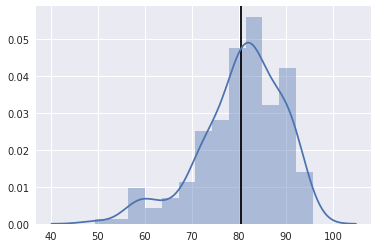

In [8]:
sns.distplot(data)
plt.vlines(np.mean(data),0,1)

Now use the right parameters to call our `bootstrap` method to obtain the sample mean $\bar{X}$ for $m$ different bootstrap samples $\{x_i\}$. 

In [9]:
m = 1000  # the number of resamples 
boot_pop = np.array(data["Grade"])

boot_sample_means = bootstrap(boot_pop, np.mean, simple_resample, replicates=m)

# YOUR CODE HERE
boot_sample_means

array([ 80.33557231,  81.27537758,  80.72957332,  80.45931148,
        80.5979897 ,  81.76662476,  81.00727661,  81.66955716,
        80.36109865,  80.71428129,  78.99161903,  80.28626346,
        81.44842628,  79.69949761,  80.34446943,  80.80793999,
        80.848541  ,  81.29183215,  80.83309721,  81.63298992,
        80.32326273,  80.58625788,  80.45306661,  81.4995197 ,
        81.36326211,  80.50440264,  80.0397261 ,  79.83465986,
        80.39721992,  81.20651875,  79.79608175,  81.52316332,
        80.15534947,  80.06312986,  80.22543109,  81.19705988,
        79.88968307,  80.24005127,  80.65478983,  79.91301851,
        80.36073929,  79.36807356,  80.81483116,  81.13444692,
        80.71594597,  79.53059675,  81.06381   ,  80.51712576,
        80.08349238,  80.59107652,  79.73518528,  80.11227042,
        80.4795513 ,  80.09732669,  79.28695473,  81.38289229,
        79.12225942,  80.6103797 ,  80.58735406,  80.4278387 ,
        80.41660252,  80.97619009,  80.41612108,  80.87

Text(0,0.5,'Frequency')

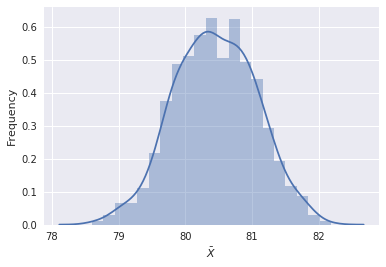

In [10]:
sns.distplot(boot_sample_means)
plt.xlabel(r"$\bar{X}$")
plt.ylabel("Frequency")

In [11]:
boot_mean_mean = np.mean(boot_sample_means)
boot_var_mean = np.var(boot_sample_means)
assert len(boot_sample_means) == m
assert 80 < boot_mean_mean < 81
assert 0.3 < boot_var_mean < 0.5

Now use the right parameters to call our `bootstrap` method to obtain the standard deviation $\sqrt{\frac{1}{n}\sum_{i=1}^{n} (x_i-\bar{X})^2}$ for $m$ different bootstrap samples $\{x_i\}$. You should use `np.std`

In [12]:
m = 1000
boot_pop = np.array(data["Grade"])

boot_sample_std = bootstrap(boot_pop, np.std, simple_resample, replicates=m)

# YOUR CODE HERE
boot_sample_std

array([  8.45307997,   8.78979146,   8.21588365,   8.706112  ,
         8.8959985 ,   9.32693197,   8.51575768,   8.33540854,
         9.08477455,   8.53286095,   8.94947593,   9.24865191,
         8.59981431,   8.18467985,   8.39010575,   8.8749619 ,
         8.48572815,   9.22243438,   9.16937361,   7.76638012,
         8.85034286,   8.72130824,   7.88592412,   8.63485621,
         8.83572846,   8.00062869,   8.75270047,   7.61174099,
         8.93778937,   9.14535316,   9.02635225,   8.55018159,
         9.1403355 ,   7.91777223,   8.78218195,   7.94551819,
         9.49385364,   9.0264296 ,   8.52671076,   9.2924568 ,
         9.24760254,   8.6973138 ,   9.03387361,   9.44930228,
         8.46219262,   8.53434693,   7.83778577,   8.93491643,
         8.87329319,   8.77470118,   8.8271474 ,   8.59299743,
         8.79138028,   8.31242539,   8.19459418,   8.04855065,
         7.8823316 ,   8.35889905,   9.63017402,   9.81889733,
         8.4869306 ,   7.78861866,   8.3497176 ,   7.82

In [13]:
boot_mean_std = np.mean(boot_sample_std)
boot_var_std = np.var(boot_sample_std)
assert len(boot_sample_std) == m
assert 7 < boot_mean_std < 10
assert 0.23 < boot_var_std < 0.29

Text(0,0.5,'Frequency')

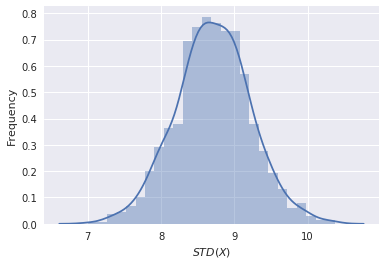

In [14]:
sns.distplot(boot_sample_std)
plt.xlabel(r"$STD(X)$")
plt.ylabel("Frequency")

The true mean for the midterm grade is 80.1, and the standard deviation is 9.20 Compare your results with them.

### Question 3
Now let's use the bootstrap method to analyze an estimator we used in the previous lab. 

Again, we use following mathematical model to predict Tips from TotalBill:

$$\Large
\texttt{Tip} = \theta^*  \times \texttt{TotalBill}
$$

This follows the similar intuition that tips are some **unknown** percentage of the total bill.  We will then try to estimate the slope of this relationship which corresponds to the percent tip. Here the parameter $\theta^*$ represents the true percent tip that we would like to estimate.

As we already know, for L2 loss function:
$$\Large
L\left(\theta, \mathcal{D}\right) = \frac{1}{n} \sum_{i=1}^n L(m_\theta(x_i), y_i) = \frac{1}{n} \sum_{i=1}^n (\theta *  x_i - y_i)^2
$$

Where, $x_i$ is the TotalBill, $y_i$ is the Tips.

The optimal $\theta$ would be:
$$\Large {\theta} = \frac{\sum x_iy_i}{\sum x_i^2}$$

Let's use the bootstrap method to see what's the variance for this estimator.


In [15]:
data = sns.load_dataset("tips")
data.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


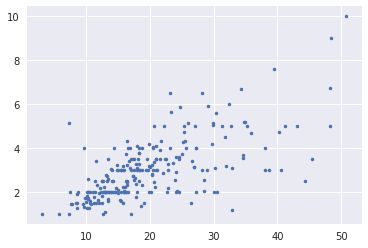

In [16]:
x = np.array(data["total_bill"])
y = np.array(data["tip"])
d = np.array((x,y)).transpose()
plt.plot(d[:,0],d[:,1],".")

Write an estimator function to compute $\theta$ using the formula:  
$$\large {\theta} = \frac{\sum x_iy_i}{\sum x_i^2}$$

Note that in order to do bootstrap, we need to combine `x`, `y` to into a $n*2$ array `d`. So `d[:,0]` is equivalent with `x` and `d[:,1]` is equivalent with `y`.

In [17]:
def estimator(d):
    """
    Args:
        d: A n*2 array which contains x and y. d[:,0] would be x, d[:,1] would be y.
        
    Returns:
        The optimal theta for this dataset under L2 loss.
    """
    # YOUR CODE HERE
    x,y = d[:,0],d[:,1]
    return np.sum(x*y)/np.sum(x*x)

In [18]:
assert np.isclose(estimator(d),0.14373189527721666)

Now let's use our previous `bootstrap` function to obtain different estimated $\theta$. You should use the `estimator` function as the `statistic` parameter.

In [19]:
replicates = 1000
boot_theta = bootstrap(d, estimator, simple_resample, replicates)

# YOUR CODE HERE
    

In [20]:
boot_theta_mean = np.mean(boot_theta)
boot_theta_var = np.var(boot_theta)
assert len(boot_theta) == replicates
assert 0.14<=boot_theta_mean<=0.15
assert boot_theta_var < 1e-4

Finally, let's plot the distribution of `boot_theta`.

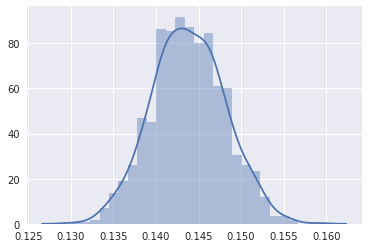

In [21]:
sns.distplot(boot_theta)

## Submission

Congrats! You are finished with this assignment. Please don't forget to submit by 11:59 pm!